In [1]:
# import the libraries
import cv2
import numpy as np
import pylab

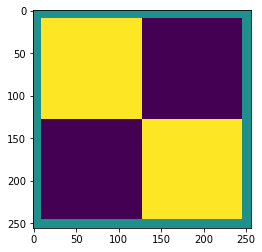

In [2]:
# load the image and convert it to grey
img = cv2.imread('ps1-input0.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
pylab.imshow(gray)
pylab.show()

Question 1.a:
---------------
apply the canny edge filter on the image.
*note:* as this image don't have any noise, we don't need to add gaussian blur

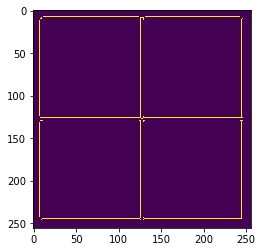

In [3]:
# apply canny edge detector
img1 = cv2.GaussianBlur( src=gray, ksize=(5,5), sigmaX=2, sigmaY=2, borderType=cv2.BORDER_REFLECT)
edges = cv2.Canny(gray,50,100,apertureSize = 7)
pylab.imshow(edges)
pylab.show()

Question 2:
-------------
Write a Hough method for finding lines.

In [4]:
# hough method parameters
N = 256 # number of subdivision for theta and d
dmax = np.math.sqrt(edges.shape[0]**2+edges.shape[1]**2)
H = np.zeros((N,N))

In [5]:
def get_H_pos(d):
    """
    return the column corresponding to d in H
    """
    return int((d + dmax) * N/(2*dmax))

def get_vote(N, dmax, H, img):
    """
    apply hough filter on the edges images
    """
    edge_points = np.argwhere(img>1)
    for point in edge_points:
        for theta_bin in range(0, N):
            theta = theta_bin*np.math.pi/N
            d = point[0] * np.math.cos(theta) - point[1] * np.math.sin(theta)
            h = get_H_pos(d)
            # print("d:"+str(d)+" H: "+str(h))
            H[h,theta_bin] = H[h,theta_bin] + 1
    return H

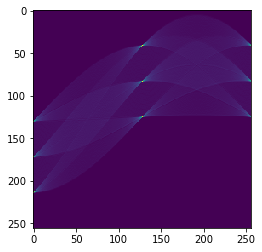

In [6]:
# apply hough algorithm
maximum = np.max(hough)
# print hough transform
hough = np.vectorize(lambda x: int(255*x/ maximum))(hough)
pylab.imshow(hough)
pylab.show()

as you can see there are 3 bright spots with the same theta=pi/2 there is also 3 bright sport with theta=pi (or 0)

In [7]:
# save picture
cv2.imwrite("ps1-2-1.jpg", hough)

True